# <center> **House Prices Prediction** </center>

**Link Competitions:** [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

**Vũ Khánh Nam**

***
## Import

In [1]:
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV , StratifiedKFold
from sklearn.metrics import mean_squared_error


**Import Dataset**

In [2]:
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')
ID_test = df_test["Id"]
df_test = df_test.drop("Id",axis=1)


df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X_train = df_train.drop(columns= ["Id", "SalePrice"])
y_train = df_train["SalePrice"]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

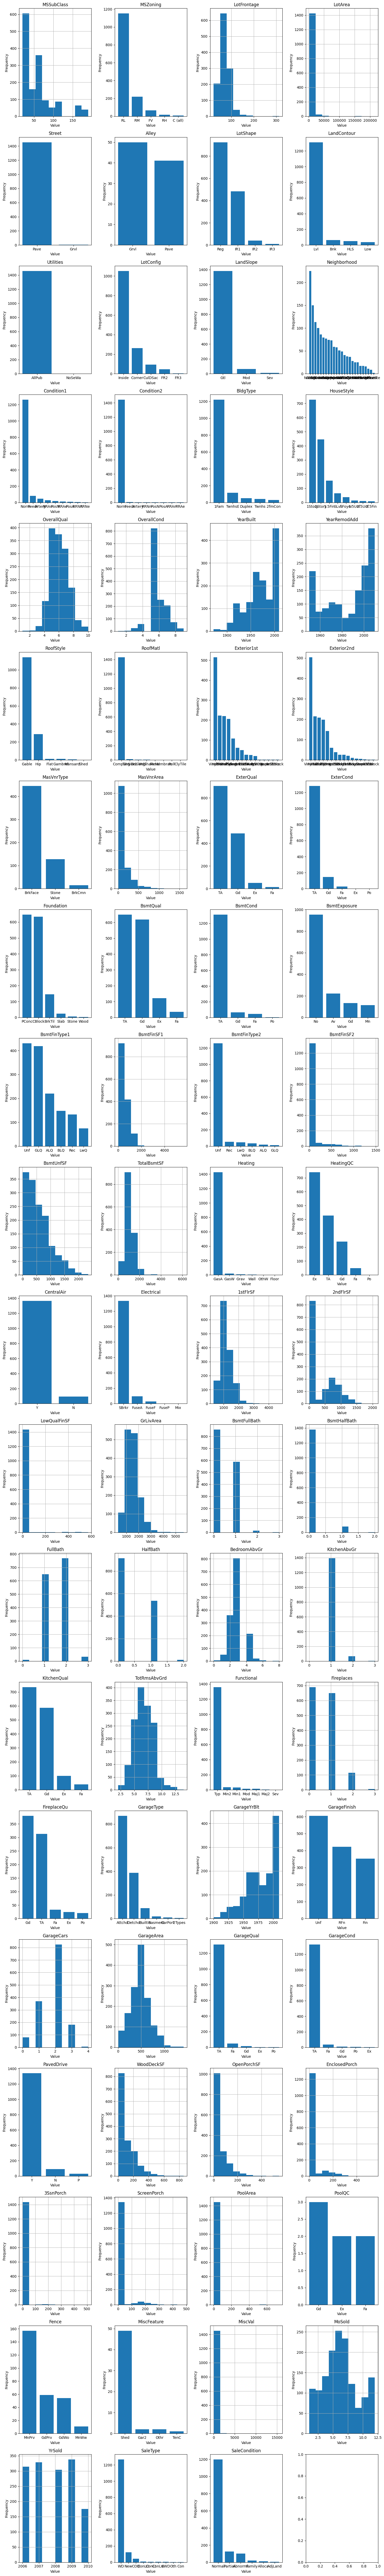

In [4]:
import matplotlib.pyplot as plt

def plot_histograms(data):
    num_columns = len(data.columns)
    num_rows = int(np.ceil(num_columns / 4))  
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 5*num_rows))  

    for i, column in enumerate(data.columns):
        row = i // 4  
        col = i % 4  

        if not data[column].dtype.kind in 'bifc':  
            value_counts = data[column].value_counts()
            axes[row, col].bar(value_counts.index, value_counts.values)  
        else:
            data[column].hist(ax=axes[row, col], bins=10)  

        axes[row, col].set_title(column)  
        axes[row, col].set_xlabel('Value')  
        axes[row, col].set_ylabel('Frequency')  

    plt.tight_layout()  
    plt.show()  

plot_histograms(X_train)

## Preprocessing

### Fill NaN values

**Training Set**

In [5]:
null_train = pd.DataFrame(X_train.isnull().sum())
null_train = null_train.loc[(null_train!=0).any(axis=1)]
null_train = null_train.transpose()
null_train

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,259,1369,872,8,37,37,38,37,38,1,690,81,81,81,81,81,1453,1179,1406


- As you can see, column "MasVnrArea" and "Electrical" have few null values.
- I have decided to replace the null values with the mean if the column contains numerical values, and with the most frequently occurring value if the column contains string values.
- Otherwise, I'll use a label encoder to assign labels to columns that have many null values.


In [6]:
X_train["MasVnrArea"].fillna(X_train["MasVnrArea"].mean(), inplace=True)
X_train["Electrical"].fillna(X_train["Electrical"].value_counts().idxmax(), inplace=True)

In [7]:
numeric_labels = []
for column in X_train.columns:
    if np.issubdtype(X_train[column].dtype, np.number):
        numeric_labels.append(column)
train_null_num_cols = [i for i in list(null_train) if i in list(numeric_labels)]

In [8]:
for col in train_null_num_cols:
    X_train[col].fillna(X_train[col].mean(), inplace=True)

**Test set**

In [9]:
null_test = pd.DataFrame(df_test.isnull().sum(),)
null_test = null_test.loc[(null_test!=0).any(axis=1)]
null_test = null_test.transpose()
null_test

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,4,227,1352,2,1,1,894,15,44,45,...,78,78,1,1,78,78,1456,1169,1408,1


In [10]:
[i for i in list(null_test) if i not in list(null_train)] #The cols, which test set have but training set not have

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [11]:
df_test["MSZoning"].fillna(X_train["MSZoning"].value_counts().idxmax(), inplace=True)
df_test["Utilities"].fillna(X_train["Utilities"].value_counts().idxmax(), inplace=True)
df_test["Exterior1st"].fillna(X_train["Exterior1st"].value_counts().idxmax(), inplace=True)
df_test["Exterior2nd"].fillna(X_train["Exterior2nd"].value_counts().idxmax(), inplace=True)
df_test["BsmtFinSF1"].fillna(X_train["BsmtFinSF1"].mean(), inplace=True)
df_test["BsmtFinSF2"].fillna(X_train["BsmtFinSF2"].mean(), inplace=True)
df_test["BsmtUnfSF"].fillna(X_train["BsmtUnfSF"].mean(), inplace=True)
df_test["TotalBsmtSF"].fillna(X_train["TotalBsmtSF"].mean(), inplace=True)
df_test["BsmtFullBath"].fillna(X_train["BsmtFullBath"].mean(), inplace=True)
df_test["BsmtHalfBath"].fillna(X_train["BsmtHalfBath"].mean(), inplace=True)
df_test["KitchenQual"].fillna(X_train["KitchenQual"].value_counts().idxmax(), inplace=True)
df_test["Functional"].fillna(X_train["Functional"].value_counts().idxmax(), inplace=True)
df_test["GarageCars"].fillna(X_train["GarageCars"].mean(), inplace=True)
df_test["GarageArea"].fillna(X_train["GarageArea"].mean(), inplace=True)
df_test["SaleType"].fillna(X_train["SaleType"].value_counts().idxmax(), inplace=True)

In [12]:
same = [i for i in list(null_test) if i in list(null_train)]
test_null_num_cols = [i for i in list(same) if i in list(train_null_num_cols)]
test_null_num_cols

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [13]:
for col in test_null_num_cols:
    df_test[col].fillna(X_train[col].mean(), inplace=True)

### Label Encoder Train and Test

In [14]:
non_numeric_labels = []
for column in X_train.columns:
    if not np.issubdtype(X_train[column].dtype, np.number):
        non_numeric_labels.append(column)

for column in non_numeric_labels:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(pd.concat([X_train[column], df_test[column]]))
    X_train[column] = label_encoder.transform(X_train[column])
    df_test[column] = label_encoder.transform(df_test[column])
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2,3,3,0,4,...,0,0,3,4,4,0,2,2008,8,4
1,20,3,80.0,9600,1,2,3,3,0,2,...,0,0,3,4,4,0,5,2007,8,4
2,60,3,68.0,11250,1,2,0,3,0,4,...,0,0,3,4,4,0,9,2008,8,4
3,70,3,60.0,9550,1,2,0,3,0,0,...,0,0,3,4,4,0,2,2006,8,0
4,60,3,84.0,14260,1,2,0,3,0,2,...,0,0,3,4,4,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,2,3,3,0,4,...,0,0,3,4,4,0,8,2007,8,4
1456,20,3,85.0,13175,1,2,3,3,0,4,...,0,0,3,2,4,0,2,2010,8,4
1457,70,3,66.0,9042,1,2,3,3,0,4,...,0,0,3,0,2,2500,5,2010,8,4
1458,20,3,68.0,9717,1,2,3,3,0,4,...,0,0,3,4,4,0,4,2010,8,4


### Disturbance handler

**Zscore Outlier**

In [15]:
class ZscoreOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold: float = 3):
        self.z_threshold = z_threshold
        self.lower = None
        self.upper = None

    def fit(self, X_train: pd.Series):
        mean = X_train.mean()
        std = X_train.std()
        self.lower = mean - self.z_threshold * std
        self.upper = mean + self.z_threshold * std
        return self

    def transform(self, X_train):
        return X_train.clip(self.lower, self.upper)

#### Training set

In [16]:
for col in list(X_train):
    X_train[col] = ZscoreOutlierClipper().fit_transform(X_train[col])

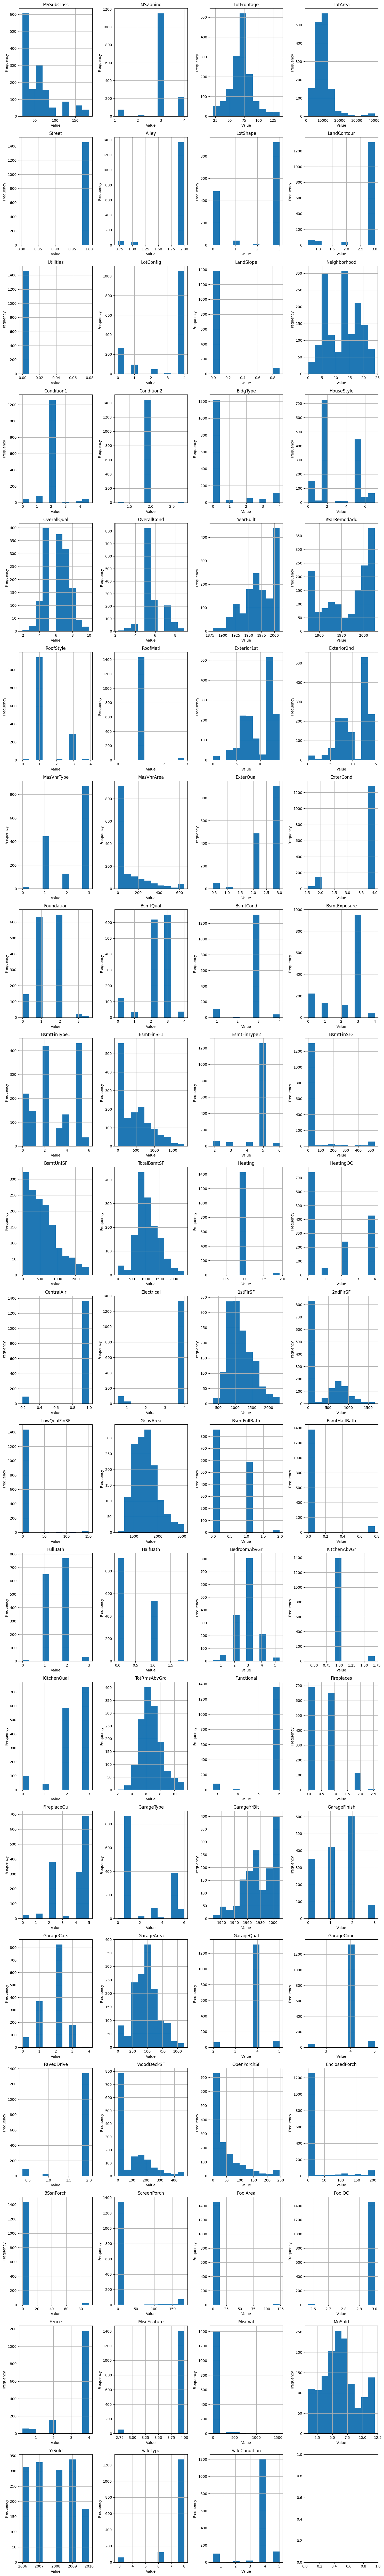

In [17]:
plot_histograms(X_train)

## Trainning Model

**XGBoost**

In [18]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(max_depth=3, n_estimators=280, learning_rate = 0.1199)
model_xgb.fit(X_train,y_train)

pred_train_xgb = model_xgb.predict(X_train)
pred_test_xgb = model_xgb.predict(df_test)

print('Train error: ', np.sqrt(mean_squared_error(y_train, pred_train_xgb)))



Train error:  9080.184782187087


**Random Forest**

In [19]:
model_rf = RandomForestRegressor(n_estimators=10, max_depth=1,)
model_rf.fit(X_train,y_train)

pred_train_rf = model_rf.predict(X_train)
pred_test_rf = model_rf.predict(df_test)

print('Train error: ', np.sqrt(mean_squared_error(y_train, pred_train_rf)))

Train error:  58665.868334229446


In [20]:
output = pd.DataFrame({'Id': ID_test, 'SalePrice': pred_test_xgb})
output.to_csv('submission.csv', index=False)
output

,Id,SalePrice
0,1461,123809.187500
1,1462,167092.718750
2,1463,181000.890625
3,1464,191200.500000
4,1465,177931.218750
...,...,...
1454,2915,74036.304688
1455,2916,75933.867188
1456,2917,154221.781250
1457,2918,123398.015625
